In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft, rfftfreq

In [3]:
def find_data_gaps(file_path, date_col, output_csv, modified_file):
    """
    Reads an Excel file, identifies continuous missing data gaps, including missing dates,
    fills in missing dates with None values, and saves the modified dataset and gaps to a CSV file.

    Parameters:
    file_path (str): Path to the input Excel file.
    date_col (str): Name of the date column.
    output_csv (str): Path to save the output CSV file.
    modified_file (str): Path to save the modified dataset with missing dates included.
    """
    # Load the dataset
    df = pd.read_excel(file_path)
    df[date_col] = pd.to_datetime(df[date_col])  # Ensure date format

    # Identify missing dates
    all_dates = pd.date_range(start=df[date_col].min(), end=df[date_col].max(), freq='D')
    existing_dates = set(df[date_col])
    missing_dates = sorted(set(all_dates) - existing_dates)

    # Identify missing hourly values (H1 to H24)
    hour_cols = [col for col in df.columns if col.startswith('H')]
    missing_entries = []

    for index, row in df.iterrows():
        missing_hours = [hour for hour in hour_cols if pd.isnull(row[hour])]
        for hour in missing_hours:
            hour_num = int(hour[1:]) - 1  # Convert H1-H24 to 0-23 hour format
            missing_entries.append({
                'Date': row[date_col],
                'Hour': f"{hour_num:02d}:00"
            })
    
    # Convert to DataFrame
    missing_df = pd.DataFrame(missing_entries)
    
    if missing_df.empty and not missing_dates:
        print("No missing data detected.")
        return
    
    # Identify continuous gaps
    missing_df['Datetime'] = pd.to_datetime(missing_df['Date'].astype(str) + ' ' + missing_df['Hour'])
    missing_datetimes = missing_df['Datetime'].tolist()
    
    # Add missing full dates as gaps (all 24 hours are missing for these dates)
    for date in missing_dates:
        for hour in range(24):
            missing_datetimes.append(date + pd.Timedelta(hours=hour))
    
    missing_datetimes.sort()
    
    start_datetime = missing_datetimes[0]
    prev_datetime = missing_datetimes[0]
    gap_index = 1
    gaps = {}

    for i in range(1, len(missing_datetimes)):
        current_datetime = missing_datetimes[i]
        if (current_datetime - prev_datetime).total_seconds() / 3600 > 1:
            gaps[f'Gap_{gap_index}'] = {'Start': start_datetime, 'End': prev_datetime}
            gap_index += 1
            start_datetime = current_datetime
        prev_datetime = current_datetime

    # Save the last gap
    gaps[f'Gap_{gap_index}'] = {'Start': start_datetime, 'End': prev_datetime}

    # Convert to DataFrame and save as CSV
    gaps_df = pd.DataFrame.from_dict(gaps, orient='index')
    gaps_df.to_csv(output_csv, index_label="Gap_ID")
    print(f"Data gaps saved to {output_csv}")

    # Add missing dates to the dataset with None values
    new_rows = []
    for date in missing_dates:
        new_row = {date_col: date}
        for hour in hour_cols:
            new_row[hour] = None
        new_rows.append(new_row)
    
    df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
    df.sort_values(by=[date_col], inplace=True)
    
    # Replace NaN values with None
    df = df.where(pd.notnull(df), None)

    # Save the modified dataset
    df.to_excel(modified_file, index=False)
    print(f"Modified dataset saved to {modified_file}")

# Example usage
port = "VISAKHA"
output_folder = "Output" 
input_file_name = f"Appended_Wave_Heights_of_{port}.xlsx"
output_file_name = f"data_gaps_{port}.csv"
modified_file_name = f"modified_wave_heights_{port}.xlsx"
input_file = os.path.join(output_folder, input_file_name)
output_file = os.path.join(output_folder, output_file_name)
modified_file = os.path.join(output_folder, modified_file_name)
find_data_gaps(input_file, 'Date', output_file, modified_file)

Data gaps saved to Output\data_gaps_VISAKHA.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_12104\3583372638.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)


Modified dataset saved to Output\modified_wave_heights_VISAKHA.xlsx


All gaps filled and saved to Output\filled_data_sequential_VISAKHA.xlsx


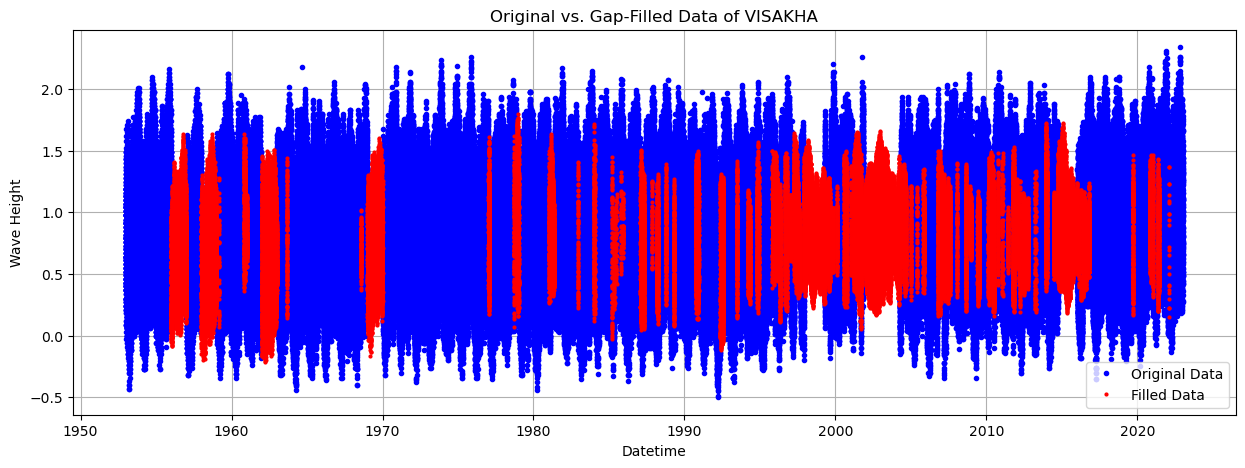

In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft, rfftfreq

def fill_missing_with_fft_sequential(input_csv, output_xlsx, full_data_xlsx, sampling_rate=24, top_n=100):
    """
    Fill missing data gaps sequentially using FFT-based interpolation.
    
    Parameters:
    input_csv (str): Path to the input CSV file containing data gaps.
    output_xlsx (str): Path to save the filled data in Excel format.
    full_data_xlsx (str): Path to the complete dataset where gaps need to be filled.
    sampling_rate (int): The sampling rate (e.g., 24 for hourly data).
    top_n (int): Number of dominant frequency components to retain.
    """
    # Load data gaps file
    gaps_df = pd.read_csv(input_csv)
    gaps_df['Start'] = pd.to_datetime(gaps_df['Start'])
    gaps_df['End'] = pd.to_datetime(gaps_df['End'])
    
    # Load full dataset from Excel
    df = pd.read_excel(full_data_xlsx)
    hour_cols = [col for col in df.columns if col.startswith('H')]
    
    # Melt the dataset to long format to create a Datetime index
    df_long = df.melt(id_vars=['Date'], value_vars=hour_cols, var_name='Hour', value_name='Value')
    df_long['Hour'] = df_long['Hour'].str.extract(r'(\d+)').astype(int) - 1  # Convert H1-H24 to 0-23
    df_long['Datetime'] = pd.to_datetime(df_long['Date'].astype(str)) + pd.to_timedelta(df_long['Hour'], unit='h')
    df_long.set_index('Datetime', inplace=True)
    df_long.sort_index(inplace=True)
    
    last_rejected_end = df_long.index.min()
    
    # Process all data gaps sequentially
    for _, row in gaps_df.iterrows():
        start, end = row['Start'], row['End']
        mask = (df_long.index >= start) & (df_long.index <= end)
        
        # Ensure prior data starts from the last rejected gap end
        prior_data = list(df_long.loc[(df_long.index >= last_rejected_end) & (df_long.index < start), 'Value'].dropna().values)
        prior_data_length = len(prior_data)
        gap_length = mask.sum()
        
        # Ensure at least one year of prior data is available
        prior_data_duration = (start - last_rejected_end).days

        # if prior_data_duration < 3  * 30 or gap_length > 6 * 30 * 24:  # Reject gaps longer than one month
        #     last_rejected_end = end
        #     continue
        
        rfft_data = rfft(prior_data, n=prior_data_length)
        freqs = rfftfreq(prior_data_length, d=1.0/sampling_rate)
        
        # Extract dominant frequencies
        amplitude = 2 / prior_data_length * np.abs(rfft_data)
        dominant_indices = np.argpartition(-amplitude, top_n)[:top_n]
        filtered_rfft_data = np.zeros_like(rfft_data, dtype=complex)
        
        for i in dominant_indices:
            filtered_rfft_data[i] = rfft_data[i]
        
        # Inverse FFT to reconstruct signal
        interpolated_data = irfft(filtered_rfft_data, n=prior_data_length + gap_length)
        
        # Replace missing values with interpolated data
        df_long.loc[mask, 'Value'] = interpolated_data[-gap_length:]
    
    # Pivot back to wide format
    df_filled = df_long.pivot(index='Date', columns='Hour', values='Value')
    df_filled.columns = [f'H{int(col) + 1}' for col in df_filled.columns]
    df_filled.reset_index(inplace=True)
    
    # Save to Excel
    df_filled.to_excel(output_xlsx, index=False)
    print(f"All gaps filled and saved to {output_xlsx}")


def plot_filled_vs_original(original_xlsx, filled_xlsx, gaps_csv, output_plot):
    """
    Plot original vs. gap-filled data in different colors for visualization.
    
    Parameters:
    original_xlsx (str): Path to the original dataset.
    filled_xlsx (str): Path to the gap-filled dataset.
    gaps_csv (str): Path to the CSV file containing data gaps.
    output_plot (str): Path to save the plot as JPEG.
    """
    # Load original and filled datasets
    df_original = pd.read_excel(original_xlsx)
    df_filled = pd.read_excel(filled_xlsx)
    gaps_df = pd.read_csv(gaps_csv)
    
    gaps_df['Start'] = pd.to_datetime(gaps_df['Start'])
    gaps_df['End'] = pd.to_datetime(gaps_df['End'])
    
    hour_cols = [col for col in df_original.columns if col.startswith('H')]
    
    # Melt both datasets
    df_original_long = df_original.melt(id_vars=['Date'], value_vars=hour_cols, var_name='Hour', value_name='Original')
    df_filled_long = df_filled.melt(id_vars=['Date'], value_vars=hour_cols, var_name='Hour', value_name='Filled')
    
    df_original_long['Hour'] = df_original_long['Hour'].str.extract(r'(\d+)').astype(int) - 1  # Convert H1-H24 to 0-23
    df_filled_long['Hour'] = df_filled_long['Hour'].str.extract(r'(\d+)').astype(int) - 1
    
    df_original_long['Datetime'] = pd.to_datetime(df_original_long['Date'].astype(str)) + pd.to_timedelta(df_original_long['Hour'], unit='h')
    df_filled_long['Datetime'] = pd.to_datetime(df_filled_long['Date'].astype(str)) + pd.to_timedelta(df_filled_long['Hour'], unit='h')
    
    # Filter only the filled gap locations
    gap_datetimes = []
    for _, row in gaps_df.iterrows():
        gap_datetimes.extend(pd.date_range(row['Start'], row['End'], freq='h'))
    
    df_filled_long = df_filled_long[df_filled_long['Datetime'].isin(gap_datetimes)]
    
    # Plot
    plt.figure(figsize=(15, 5))
    plt.plot(df_original_long['Datetime'], df_original_long['Original'], 'bo', markersize=3, label='Original Data')
    plt.plot(df_filled_long['Datetime'], df_filled_long['Filled'], 'ro', markersize=2, label='Filled Data')
    plt.xlabel('Datetime')
    plt.ylabel('Wave Height')
    plt.title(f'Original vs. Gap-Filled Data of {port}')
    plt.legend()
    plt.grid()
    plt.savefig(output_plot, format='jpeg', dpi=300)
    plt.show()

# Example usage
port = "VISAKHA"
output_folder = "Output"
input_file_name = f"data_gaps_{port}.csv"
full_data_file_name = f"modified_wave_heights_{port}.xlsx"
output_file_name = f"filled_data_sequential_{port}.xlsx"
plot_file_name = f"filled_vs_original_{port}.jpeg"
input_file = os.path.join(output_folder, input_file_name)
full_data_file = os.path.join(output_folder, full_data_file_name)
output_file = os.path.join(output_folder, output_file_name)
plot_file = os.path.join(output_folder, plot_file_name)

fill_missing_with_fft_sequential(input_file, output_file, full_data_file)
plot_filled_vs_original(full_data_file, output_file, input_file, plot_file)